In [1]:
import gym #Import gym library from OpenAI
import matplotlib.pyplot as plt
import numpy as np
import sneks
from tqdm import tqdm_notebook as tqdm #Used to follow the progression.

import time
import pickle #used to store the different generations

env = gym.make('babysnek-raw-16-v1') #Create the environment.*

In [2]:
%matplotlib notebook

def get_rgb_from_val(val):
    val = min(1,max(-1,val))
    if(val >= 0):
        v = int((1-val)*255)
        return '#%02x%02x%02x' % (v, 255, v)
    
    v = int(-val*255)
    return '#%02x%02x%02x' % (255, v, v)

def load_display_neural_network():
    global fig
    plt.rcParams['axes.facecolor'] = 'black'
    fig,ax = plt.subplots(1,1)


def display_neural_network(inputs, layers, biases, outputs):
    
    plt.clf()
    plt.rcParams['axes.facecolor'] = 'black'
    plt.xlabel("Layers")
    plt.ylabel("Neurons")
    
    local_layers = layers.copy() #Avoid to edit networks' layer.
    local_layers.append(outputs)
    
    
    max_high = 0
    
    for li in local_layers: #Used for vertical alignment.
        max_high = max(max_high, li.shape[0])
        max_high = max(max_high, li.shape[1])
    
    for i, layer in enumerate(local_layers):
        inputs = inputs.reshape(-1)
        if(i < len(biases)):
            biases[i] = biases[i].reshape(-1)
        next_layer = []
        for nout, neuron in enumerate(layer):
            neuron_strength = 0
            for nin, weight in enumerate(neuron):
                v = inputs[nin]
                val = weight * v
                neuron_strength += val
                
                plt.plot([i, i+1],
                         [nin/(len(neuron)-1)*max_high, nout/(len(layer)-1)*max_high],
                         color = get_rgb_from_val(val), marker="o",
                         alpha = 1 if abs(val) > 0.5 else (abs(max(0,min(1,val))/125)+0.25))
            
            if(i < len(biases)):
                plt.plot([i, i+1],
                         [-1, nout/(len(layer)-1)*max_high], 
                         color = get_rgb_from_val(biases[i][nout]), marker="o",
                         alpha = 1 if abs(val) > 0.5 else (abs(max(0,min(1,biases[i][nout]))/125)+0.25))
                                  
                neuron_strength += biases[i][nout]
            
            next_layer.append(neuron_strength)
        next_layer = np.array(next_layer)
        
        for anid, activated_neuron in enumerate(inputs):#Displaying last layer.
            plt.plot([i],[anid/(len(inputs)-1)],
                     color = get_rgb_from_val(activated_neuron), marker="o")
            
        if(i != len(local_layers) - 1): #Not the last layer.
            inputs = sigmoid_activate(next_layer)
            
    
    inputs = softmax_activate(next_layer.reshape(-1))
    
    for anid, activated_neuron in enumerate(inputs):#Displaying last layer.
        plt.plot([len(local_layers)],[anid/(len(inputs)-1)*max_high],
                 color = "#a8a8a8" if anid != inputs.argmax() else "#ff0000", marker="o")
        
    fig.canvas.draw()
    return inputs

In [3]:
def rand_s():
        for noutid, nout in enumerate(layer):
            for nid, n in enumerate(results[lid]):
                plt.plot([lid, lid+1], [nid, noutid], marker = "o", color=get_rgb_from_val(n[0]))
            if(lid < len(biases)):
                for bias in biases[lid]:
                    plt.plot([lid, lid+1], [-1, noutid], marker = "o", color=get_rgb_from_val(bias))

        
        
class NeuralNetwork():
    def __init__(self, observation_size, isACopy=False):
        self._rewards = 0
        self._layers = []
        self._biases = []
        
        if(not isACopy):
            for i in range(nb_layers):
                entry_size = neurons if i != 0 else observation_size
                self._layers.append(np.random.rand(neurons,entry_size)*2-1)
                self._biases.append(np.random.rand(neurons,1)*2-1)


            self._outputs = np.random.rand(4,neurons)*2-1


    def forward(self, inputs,displayGraph=False):
        inputs = update_observations(inputs) #We update the observation size.
        inputs = inputs.reshape((-1,1))
        
        if(displayGraph):
            return display_neural_network(inputs, self._layers, self._biases, self._outputs)

        for layer, bias in zip(self._layers, self._biases):
            inputs = np.matmul(layer,inputs)
            inputs = inputs+bias
            inputs = sigmoid_activate(inputs)
            
        inputs = np.matmul(self._outputs, inputs)
        inputs = inputs.reshape(-1)
        
        
        
        
        return softmax_activate(inputs)

    def mutate(self):
        new_snake = NeuralNetwork(self._layers[0].shape[1],isACopy=True)
        
        for l in self._layers:
            random_mutation_probs = np.random.rand(l.shape[0], l.shape[1])
            
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation,
                                             (np.random.rand()-0.5)/2, 0)
            new_l = l + random_mutation_probs
            new_snake._layers.append(new_l)
            
            
        for b in self._biases:
            random_mutation_probs = np.random.rand(b.shape[0], 1)
            random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation,
                                             (np.random.rand()-0.5)/2, 0)
            new_l = b + random_mutation_probs
            new_snake._biases.append(new_l)
    
    
        random_mutation_probs = np.random.rand(self._outputs.shape[0],self._outputs.shape[1])
        random_mutation_probs = np.where(random_mutation_probs < chances_of_mutation,
                                         (np.random.rand()-0.5)/2, 0)
        
        new_l = self._outputs + random_mutation_probs
        new_snake._outputs = new_l
        return new_snake

    def set_reward(self, r):
        self._reward = r

def update_observations(observation, view_size = 2):
    assert view_size > 0, "The agent cannot see the map if you don't set a view_size over 0!"
    
    cliffs = np.ones((observation.shape[0]+2,observation.shape[1]+2))
    cliffs *= 100
    cliffs[1:cliffs.shape[0]-1,1:cliffs.shape[1]-1] = observation
    
    observation = cliffs
    
    localization = np.argwhere(observation == 101).reshape(-1)
    
    fruit_localization = np.argwhere(observation == 255).reshape(-1)
    high = (localization[0] - fruit_localization[0])
    width = (localization[1] - fruit_localization[1])
    high = min(max(-1,high),1)
    width = min(max(-1,width),1)
    
    observation = np.roll(observation,int(observation.shape[0]/2)-localization[0], axis = 0)
    observation = np.roll(observation,int(observation.shape[1]/2)-localization[1], axis = 1)
    
    
    localization = np.argwhere(observation == 101).reshape(-1)
    
    observation = observation[localization[0]-view_size:localization[0]+view_size+1,
                       localization[1]-view_size:localization[1]+view_size+1]
    
    observation = np.reshape(observation, (-1)) 
    localization = np.argwhere(observation == 101).reshape(-1)[0]
    observation = np.delete(observation, localization)
    
    
    observation = np.where(observation == 255, 1, observation) #We replace the fruit by 1.
    observation = np.where(observation == 100, -1, observation) #We replace the wall & tail by 1.
    
    observation = np.concatenate((observation, [high, width]))
    return observation
#We create function to compare our snakes.
def save_snake(id_iteration):
    with open("snake_{}.obj".format(id_iteration),'wb') as file_save:
        #We create a dict of the snake parameters
        to_save = {"layers":farm[0]._layers,
                     "biases":farm[0]._biases,
                     "outputs":farm[0]._outputs}
        #And save it using picke
        pickle.dump(to_save,file_save, protocol=pickle.HIGHEST_PROTOCOL)

def load_snake(id_iteration):
    with open("snake_{}.obj".format(id_iteration),'rb') as file_save:
        
        snake_params = pickle.load(file_save)

        snake = NeuralNetwork(obs_size)
        snake._layers = snake_params["layers"]
        snake._biases = snake_params["biases"]
        snake._outputs = snake_params["outputs"]
        
        return snake

def sigmoid_activate(layer): #Sigmoid function
    return 1/(1+np.exp(-layer))


def softmax_activate(layer): #Softmax function
    m = np.exp(layer)
    return m/m.sum(len(layer.shape)-1)

neurons = 10 #We reduce the size of the network.
nb_layers = 3 #We set up 3 hidden layers.
obs_size = update_observations(env.reset()).shape[0] #We reduce the size of the input...
                                                        #which is used for the definition of the snakes!

snake = load_snake("ideal")

<IPython.core.display.Javascript object>


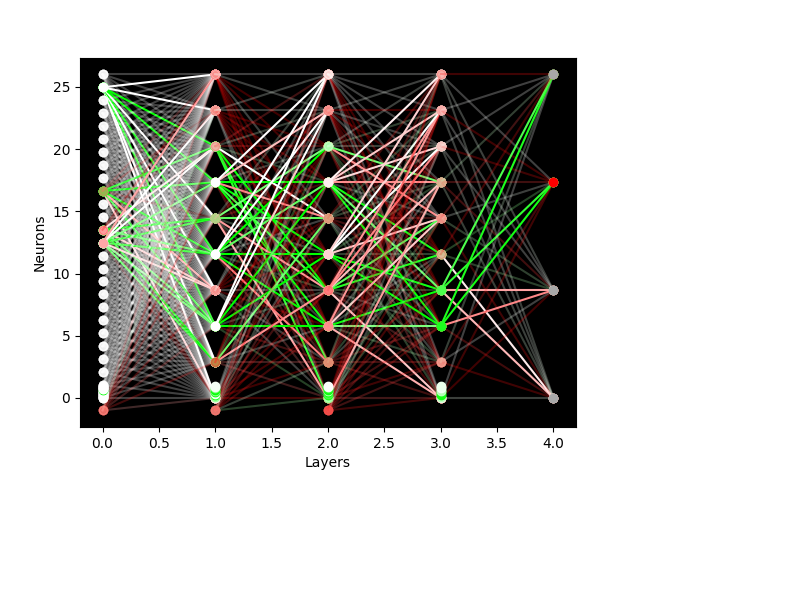

In [ ]:
load_display_neural_network()
while(True):
    done = False
    observation = env.reset()
    env.render()
    while(not done):
        observation, res, done, info = env.step(snake.forward(observation, True).argmax())
        env.render()